In [1]:
import os
import tarfile
import urllib.request

URL_HAM = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2'
URL_SPAM = 'https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2'
path = 'datasets\\spam'

def construct_path(PATH,url_ham,url_spam):
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    for file_name,url in (('_ham.tar.bz2',url_ham),("_spam.tar.bz2",url_spam)):
        file_path = os.path.join(PATH,file_name)
        if not os.path.isfile(file_path):
            urllib.request.urlretrieve(url,file_path)
        tar_bz2_file = tarfile.open(file_path)
        tar_bz2_file.extractall(path=path)#extrai todos os arquivos do mesmo diretorio
        tar_bz2_file.close()

In [2]:
construct_path(path,URL_HAM,URL_SPAM)

In [3]:
HAM_DIR = os.path.join(path, "easy_ham")
SPAM_DIR = os.path.join(path, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) ][:-1]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) ][:-1]

In [4]:
len(spam_filenames)

500

In [5]:
from email.parser import BytesParser, Parser
from email.policy import default

def open_files(name,dire):
    with open(os.path.join(dire,name),'rb') as fp:
        headers = BytesParser(policy=default).parse(fp)
    return headers

In [6]:
ham_emails = [open_files(name,HAM_DIR) for name in ham_filenames]
spam_emails = [open_files(name,SPAM_DIR) for name in spam_filenames]

In [7]:
print(spam_emails[7].keys())
print(spam_emails[7].values())

print(spam_emails[12].get_content_type())

['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Message-Id', 'Received', 'Date', 'From', 'To', 'Subject', 'X-Info', 'X-Info2', 'Mime-Version', 'Content-Type']
['<OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM@SMTP1.ADMANMAIL.COM>', 'zzzz@localhost.spamassassin.taint.org', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 71CE443F9B\tfor <zzzz@localhost>; Thu, 22 Aug 2002 13:28:19 -0400 (EDT)', 'from mail.webnote.net [193.120.211.219]\tby localhost with POP3 (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 18:28:19 +0100 (IST)', 'from TIPSMTP1.ADMANMAIL.COM (TIPSMTP1.ADMANMAIL.COM [209.216.124.212])\tby webnote.net (8.9.3/8.9.3) with ESMTP id SAA05985\tfor <JM@NETNOTEINC.COM>; Thu, 22 Aug 2002 18:27:56 +0100', '<200208221727.SAA05985@webnote.net>', 'from tiputil1 (10.2.0.30) by TIPSMTP1.ADMANMAIL.COM (LSMTP for Windows NT v1.1b) with SMTP id <123.000035F8@TIPSMTP1.ADMANMAIL.COM>; Thu, 22 Aug 2002 1

In [9]:
import matplotlib.pyplot as plt

dct = {}

for email_type in ham_emails:
    dct[email_type.get_content_type()] = dct.get(email_type.get_content_type(),0)+1
dct

{'text/plain': 2408,
 'multipart/signed': 68,
 'multipart/alternative': 9,
 'multipart/mixed': 10,
 'multipart/related': 3,
 'multipart/report': 2}

In [10]:
dct2 = {}
for email_type in spam_emails:
    dct2[email_type.get_content_type()] = dct2.get(email_type.get_content_type(),0)+1
dct2

{'text/html': 183,
 'text/plain': 218,
 'multipart/mixed': 43,
 'multipart/alternative': 47,
 'multipart/related': 9}

In [11]:
import pandas as pd

def change(dictio):
    soma = sum(dictio.values())
    for key,value in zip(dictio.keys(),dictio.values()):
        dictio[key] = dictio[key]/soma
        
change(dct)        
change(dct2)

<AxesSubplot:>

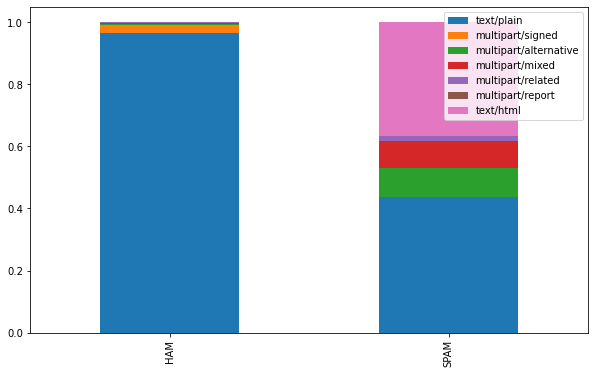

In [12]:
Ham = pd.Series(dct)

Spam = pd.Series(dct2)

data = pd.DataFrame([Ham,Spam])
data.index = ['HAM','SPAM']
data.plot(kind='bar',stacked=True,figsize =(10,6))

Observa-se uma maior concentração de Text/plain e multipart/signed nos email tipo HAM
E Text/html / Multipart/alternative / mixed

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails,dtype='object')
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =42)

Função para remover a formatação do HTML

In [14]:
import re

regex = re.compile(r'<[^>]+>')
def remove_html(string):
    text = regex.sub('', string)
    return text.replace('\n','')

Eu construi uma função para pegar qualquer email e torná-lo uma string, como foi observado existem diversos tipos de emails como do tipo 'text/html', neste tipo usarei a função anterior para remover toda a formatação e retirar apenas o texto, e também existem outros tipos com partes diferentes ou 'multipart', destes eu tenho que realizar uma operação específica usando o método payload da biblioteca email.

In [15]:
def email_to_str(email):   
        for part in email.walk():
            try :
                if part.get_content_type() == 'text/plain':
                    cont = part.get_content()
                    return cont
                else:
                    cont = remove_html(str(part.get_content()))                   
                    return cont
            except:
                emails = part.get_payload()
                try:
                    for email in emails:
                        if not type(email) == str:
                            if email.get_content_type == 'text/plain':
                                cont = email.get_content()
                                return cont
                            else:
                                cont = remove_html(str(email.get_content()))
                                return cont   
                        else:

                            return remove_html(emails)
                except:
                    pass

In [16]:
from nltk.stem import PorterStemmer
def dct(email):
    vocabulary =[]
    ps = PorterStemmer()
    word_count={}
    for word in email.split():
        word_count[ps.stem(word)] = word_count.get(ps.stem(word),0)+1
        
    return {key:value for key,value in sorted(word_count.items(),key = lambda x:x[1],reverse=True)}

In [18]:
def remove_all(email):
    urls =  re.findall(r'(https?://\S+)',email)
    punctuation= '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    
    for url in urls:
        email = email.replace(url,'URL')#remove URL

    for letter in email:#remove pontuação
        if letter in punctuation:
            email = email.replace(letter,' ')
        
    email = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', email)
    
    
    return email

Vou criar uma função que criará uma matriz esparsa, está conterá em cada linha os emails e as palavras mais usadas de todos os emails e sua respectiva quantidade 

In [19]:
from scipy.sparse import csr_matrix

def Final_Transform(emails,largura):
    X_train_transformed_ind = [str(email_to_str(email)) for email in emails]
    X_train_transformed_ind_dic  = [dct(remove_all(email)) for email in X_train_transformed_ind]
    X_train_transformed ='-'.join(X_train_transformed_ind)
    tmu_words = dct(remove_all((X_train_transformed)))
    vocabulary ={key:i+1 for i,key in enumerate(tmu_words.keys())}


    colunas = []
    dados = []
    linhas = []

    for i in range(len(X_train_transformed_ind_dic)):

        for word in list(vocabulary)[:largura]:
            colunas.append(vocabulary[word])

            dados.append(X_train_transformed_ind_dic[i].get(word,0))

    numb = 0
    for num,dicio in enumerate(X_train_transformed_ind_dic):
        contar = 0
        for word in dicio:
            if word not in list(vocabulary)[:largura]:
                contar += 1
        linhas.insert(0,numb)
        numb+=1
        dados.insert(0,contar)
        colunas.insert(0,0)

    for i in range(len(X_train_transformed_ind_dic)):    
        for word in range(len(list(vocabulary)[:largura])):
            linhas.append(i)

    sparseMatrix = csr_matrix((dados, (linhas, colunas)), shape = (len(X_train_transformed_ind_dic),len(list(vocabulary)[:largura])+1))


    return sparseMatrix
X_train_transformed = Final_Transform(X_train,1000)

array([[ 3,  0,  0, ...,  0,  0,  0],
       [34,  0, 11, ...,  0,  0,  0],
       [16,  1,  0, ...,  0,  0,  0],
       ...,
       [61, 26, 20, ...,  0,  0,  0],
       [14,  6,  2, ...,  0,  0,  0],
       [61, 25, 11, ...,  0,  0,  0]], dtype=int32)

Observe que na primeira coluna eu coloquei a quantidade palavras que não estão entre as mais usadas entre os emails, a função final_transform tem dois parametros os emails e a quantidade de palavras mais usadas que eu desejo que apareça no caso foram 1000 palavras mais usadas. 

In [21]:
X_train_transformed.toarray()

array([[ 3,  0,  0, ...,  0,  0,  0],
       [34,  0, 11, ...,  0,  0,  0],
       [16,  1,  0, ...,  0,  0,  0],
       ...,
       [61, 26, 20, ...,  0,  0,  0],
       [14,  6,  2, ...,  0,  0,  0],
       [61, 25, 11, ...,  0,  0,  0]], dtype=int32)

In [20]:
X_test_transform = Final_Transform(X_test,1000)

In [143]:
X_train_transformed

<2400x1001 sparse matrix of type '<class 'numpy.intc'>'
	with 2402400 stored elements in Compressed Sparse Row format>

In [144]:
X_test_transform

<600x1001 sparse matrix of type '<class 'numpy.intc'>'
	with 600600 stored elements in Compressed Sparse Row format>

In [28]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

log_clf2 = LogisticRegression(max_iter=1000,solver="lbfgs")

log_clf2.fit(X_train_transformed,y_train)
y_pred = log_clf2.predict(X_test_transform)


print('Acurácia de :',(100* accuracy_score(y_test,y_pred)),'%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.985) total time=   2.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ................................ score: (test=0.989) total time=   4.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] END ................................ score: (test=0.993) total time=   3.9s
Pontuação de : [98.5   98.875 99.25 ] %
Acurácia de : 85.83333333333333 %


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s finished


Vamos aprimorar o modelo

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {'C':uniform(0.01,1)}
rnd_search_cv = RandomizedSearchCV(log_clf2, param_distributions, n_iter=20, verbose=2, cv=3)
rnd_search_cv.fit(X_train_transformed,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...............................C=0.8795513525322767; total time=   2.5s
[CV] END ...............................C=0.8795513525322767; total time=   3.9s
[CV] END ...............................C=0.8795513525322767; total time=   4.3s
[CV] END ...............................C=0.1335982840122193; total time=   2.3s
[CV] END ...............................C=0.1335982840122193; total time=   3.0s
[CV] END ...............................C=0.1335982840122193; total time=   3.6s
[CV] END ...............................C=0.6253164393621798; total time=   3.0s
[CV] END ...............................C=0.6253164393621798; total time=   4.2s
[CV] END ...............................C=0.6253164393621798; total time=   3.8s
[CV] END ................................C=0.724181160848532; total time=   3.9s
[CV] END ................................C=0.724181160848532; total time=   4.3s
[CV] END ................................C=0.724

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000199E2C54670>},
                   verbose=2)

In [25]:
rnd_search_cv.best_estimator_

LogisticRegression(C=0.37303450303870345, max_iter=1000)

In [27]:
rnd_search_cv.best_estimator_.fit(X_train_transformed,y_train)
y_pred = rnd_search_cv.best_estimator_.predict(X_test_transform)
print('Acurácia de :',(100* accuracy_score(y_test,y_pred)),'%')

Acurácia de : 86.83333333333333 %
